In [1]:
from datetime import datetime
import sys
import time
from SPARQLWrapper import SPARQLWrapper, JSON
import requests
from PIL import Image
import html

endpoint_url = "https://computational-publishing-service.wikibase.cloud/query/sparql"
#where the sparql queries come from

query_txt = """PREFIX cps: <https://computational-publishing-service.wikibase.cloud/entity/>
PREFIX cpss: <https://computational-publishing-service.wikibase.cloud/entity/statement/>
PREFIX cpsv: <https://computational-publishing-service.wikibase.cloud/value/>
PREFIX cpspt: <https://computational-publishing-service.wikibase.cloud/prop/direct/>
PREFIX cpsp: <https://computational-publishing-service.wikibase.cloud/prop/>
PREFIX cpsps: <https://computational-publishing-service.wikibase.cloud/prop/statement/>
PREFIX cpspq: <https://computational-publishing-service.wikibase.cloud/prop/qualifier/>

SELECT ?textItem ?kuratorLabel ?textUrl
WHERE
{
  <placeholder>
  ?textItem cpsp:P46 ?kuratorStatement. 
  ?kuratorStatement cpsps:P46 ?kuratorItem.   
  ?kuratorItem rdfs:label ?kuratorLabel.
  ?textItem cpsp:P57 ?urlstatement. 
  ?urlstatement cpsps:P57 ?textUrl. 
}"""

query_img = """PREFIX cps: <https://computational-publishing-service.wikibase.cloud/entity/>
PREFIX cpss: <https://computational-publishing-service.wikibase.cloud/entity/statement/>
PREFIX cpsv: <https://computational-publishing-service.wikibase.cloud/value/>
PREFIX cpspt: <https://computational-publishing-service.wikibase.cloud/prop/direct/>
PREFIX cpsp: <https://computational-publishing-service.wikibase.cloud/prop/>
PREFIX cpsps: <https://computational-publishing-service.wikibase.cloud/prop/statement/>
PREFIX cpspq: <https://computational-publishing-service.wikibase.cloud/prop/qualifier/>

SELECT DISTINCT ?itemLabel ?itemDescr ?imgItem ?imgUrl ?publishDate 
WHERE
{
  ?imgItem cpsp:P107 ?urlStatement. 
  ?urlStatement cpsps:P107 ?imgUrl. 
  ?imgItem cpsp:P60 ?dateStatement.         
  ?dateStatement cpsps:P60 ?publishDate.
  ?imgItem cpsp:P6 ?partOfStatement.
  ?partOfStatement cpsps:P6 ?partOfItem.
  <placeholder> 
  SERVICE wikibase:label {
      bd:serviceParam wikibase:language "de,en".
      ?imgItem rdfs:label ?itemLabel.
      ?imgItem schema:description ?itemDescr.
    }
}"""
query_graph = """PREFIX cps: <https://computational-publishing-service.wikibase.cloud/entity/>
PREFIX cpss: <https://computational-publishing-service.wikibase.cloud/entity/statement/>
PREFIX cpsv: <https://computational-publishing-service.wikibase.cloud/value/>
PREFIX cpspt: <https://computational-publishing-service.wikibase.cloud/prop/direct/>
PREFIX cpsp: <https://computational-publishing-service.wikibase.cloud/prop/>
PREFIX cpsps: <https://computational-publishing-service.wikibase.cloud/prop/statement/>
PREFIX cpspq: <https://computational-publishing-service.wikibase.cloud/prop/qualifier/>

SELECT ?x ?y
WHERE
{
  ?a cpsp:P2 ?c.
  ?c cpsps:P2 ?d.                       #also quasi überall wo sparql ist, muss was angepasst werden
  ?a rdfs:label ?x.
  ?d rdfs:label ?y.

}LIMIT 1"""

query_graph2 = """
SELECT ?a ?b ?c
WHERE
{
  ?a rdfs:label ?c
}LIMIT 100"""


def run_query(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setMethod("POST") #this NEEDS to be added to get results (not included in the wikibase python example code)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

def get_text(textitem_id):
    q = ""
    if textitem_id:
        q = query_txt.replace("<placeholder>", "cps:"+textitem_id+" cpsp:P46 ?kuratorStatement.")
    else:
        q = query_txt.replace("<placeholder>","")

    results_txt = run_query(endpoint_url, q)
    for item in results_txt["results"]["bindings"]:
        # print(item)
        print('Wikibase link: ' + '[' + item['textItem']['value'] + ']' + '(' + item['textItem']['value'] + ')' + '\n')
        print('Kurator: ' + item['kuratorLabel']['value'] + '\n')
        headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
        r = requests.get(item['textUrl']['value'], headers=headers, stream=True)
        text = str(r.content)
        text = text.replace("ä","&auml;")
        text = text.replace("Ä","&Auml;")
        text = text.replace("ö","&ouml;")
        text = text.replace("Ö","&Ouml;")
        text = text.replace("ü","&uuml;")
        text = text.replace("Ü","&Uuml;")
        text = text.replace("ß","&szlig;")
        text = text.replace('\\n',"<br>")
        text = str(text)
        text = text.removeprefix("b'<!DOCTYPE html>").removesuffix("'")
        print(text)

def get_delay(date):
    try:
        date = datetime.datetime.strptime(date, '%a, %d %b %Y %H:%M:%S GMT')
        timeout = int((date - datetime.datetime.now()).total_seconds())
    except ValueError:
        timeout = int(date)
    return timeout

def fetch_image_by_url(url, headers):
    r = requests.get(url, headers=headers, stream=True)
    if r.status_code == 200:
        im = Image.open(r.raw)
        return im
    if r.status_code == 500:
        return None
    if r.status_code == 403:
        return None
    if r.status_code == 429:
        timeout = get_delay(r.headers['retry-after'])
        print('Timeout {} m {} s'.format(timeout // 60, timeout % 60))
        time.sleep(timeout)
        fetch_image_by_url(url, headers)

def get_img(partOfItem_id):
    q = ""
    if partOfItem_id:
        q = query_img.replace("<placeholder>", "?partOfStatement cpsps:P6 cps:"+partOfItem_id+".")
    else:
        q = query_img.replace("<placeholder>","")
    results_img = run_query(endpoint_url, q)
    for item in results_img["results"]["bindings"]:    
      #print(item)
      print('Wikibase link: ' + '[' + item['imgItem']['value'] + ']' + '(' + item['imgItem']['value'] + ')' + '\n')
      print('Title: ' + item['itemLabel']['value'] + '\n')
      print('Year: ' + item['publishDate']['value'] + '\n')
      print('Description: ' + html.unescape(item['itemDescr']['value']) + '\n')

      # get image from image URL and display resized version
      image_url=item['imgUrl']['value']
      headers = {'User-Agent': 'Ex_Books_conference_bot/0.0 (https://github.com/SimonXIX/Experimental_Books_workshop; ad7588@coventry.ac.uk)'}
      im = fetch_image_by_url(image_url, headers)
      im.thumbnail((500, 500), Image.Resampling.LANCZOS)
      display(im)
      print('\n\n')

def get_graph():
    import VizKG.visualize as vkg
    results_graph1 = run_query(endpoint_url, query_graph)
    #print(results_graph1)
    #print('---')
    results_graph2 = run_query(endpoint_url, query_graph2)
    #print(results_graph2)

    chart = vkg(sparql_query=query_graph2, sparql_service_url=endpoint_url, chart='wordcloud')
    chart.plot()


**How to use your own text for processing**

1. Add a new Text item to the wikibase. [link to wikibase new item](https://computational-publishing-service.wikibase.cloud/wiki/Special:NewItem) the item should contain the following statements: 
* P57 (external link): link to the html file containing the new text
* P46 (kurator): Item of the curator. you may use an existing item like Q210 (Ulrike seeger) for test purposes
* P53 (license): Item of a license for the text. e.g Q203 (CC BY-NC-ND 4.0 DEED )
* P6 (is part of): set value to Q218 (Schlossanlage Weikersheim)

2. check if your new text item occurs in the list of selected text items: [Link to wikibase query service](https://computational-publishing-service.wikibase.cloud/query/#PREFIX%20cps%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fentity%2F%3E%0APREFIX%20cpss%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fentity%2Fstatement%2F%3E%0APREFIX%20cpsv%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fvalue%2F%3E%0APREFIX%20cpspt%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fprop%2Fdirect%2F%3E%0APREFIX%20cpsp%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fprop%2F%3E%0APREFIX%20cpsps%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fprop%2Fstatement%2F%3E%0APREFIX%20cpspq%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fprop%2Fqualifier%2F%3E%0A%0ASELECT%20%3FtextItem%20%3FkuratorLabel%20%3FtextUrl%0AWHERE%0A%7B%0A%20%20%3FtextItem%20cpsp%3AP46%20%3FkuratorStatement.%20%0A%20%20%3FkuratorStatement%20cpsps%3AP46%20%3FkuratorItem.%20%0A%20%20%3FkuratorItem%20rdfs%3Alabel%20%3FkuratorLabel.%0A%20%20%3FtextItem%20cpsp%3AP57%20%3Furlstatement.%20%0A%20%20%3Furlstatement%20cpsps%3AP57%20%3FtextUrl.%20%0A%7D)

3. set parameter of get_text() to the id of your new text item e.g.: get_text("Q209")

In [2]:
get_text("Q232")
#Text zur Tafelstube

Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q232](https://computational-publishing-service.wikibase.cloud/entity/Q232)

Kurator: Seeger, Ulrike

<br><head><br>  <meta charset="utf-8" /><br>  <meta content="text" /><br>  <meta name="viewport" content="width=device-width, initial-scale=1.0" /><br></head><br><html xmlns="http://www.w3.org/1999/xhtml" lang="de" xml:lang="de"><br>  <body><br>    <h5>Die Tafelstube</h5><br>    <h6>Beschreibung</h6><br>    <p><br>      \xc3\x96stlich an den Rittersaal schlie\xc3\x9ft ein gro\xc3\x9fer, 1837 unterteilter Raum an, bei dem es sich um die einstige Tafelstube handelt.[1] Als Eckraum mit vier Doppelfenstern zur Gartenseite und weiteren drei Doppelfenstern zur Grabenseite erhielt die Tafelstube viel Licht. Auch konnte der F\xc3\xbcrst von dort aus auf die Stadt und den Lustgarten blicken, der in der Renaissance dem Schloss s\xc3\xbcd\xc3\xb6stlich vorgelagert war.[2] Gemessen an der Gr\xc3\xb6\xc3\x9fe des Raumes w

<hr>

**How to select images for processing**

Images are selected via the sparql query. The method get_img() is capable of using a wikibase item id as parameter to select images with the property P6 (is part of) linking to the given item id.

1. select a valid location id from the query result: [Link to wikibase query service](https://computational-publishing-service.wikibase.cloud/query/#PREFIX%20cps%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fentity%2F%3E%0APREFIX%20cpss%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fentity%2Fstatement%2F%3E%0APREFIX%20cpsv%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fvalue%2F%3E%0APREFIX%20cpspt%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fprop%2Fdirect%2F%3E%0APREFIX%20cpsp%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fprop%2F%3E%0APREFIX%20cpsps%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fprop%2Fstatement%2F%3E%0APREFIX%20cpspq%3A%20%3Chttps%3A%2F%2Fcomputational-publishing-service.wikibase.cloud%2Fprop%2Fqualifier%2F%3E%0A%0ASELECT%20DISTINCT%20%3FpartOfItem%20%3FpartOfItemLabel%0AWHERE%0A%7B%0A%20%20%3FimgItem%20cpsp%3AP107%20%3FurlStatement.%20%0A%20%20%3FurlStatement%20cpsps%3AP107%20%3FimgUrl.%20%0A%20%20%3FimgItem%20cpsp%3AP60%20%3FdateStatement.%20%0A%20%20%3FdateStatement%20cpsps%3AP60%20%3FpublishDate.%20%0A%20%20%3FimgItem%20cpsp%3AP6%20%3FpartOfStatement.%0A%20%20%3FpartOfStatement%20cpsps%3AP6%20%3FpartOfItem.%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22de%2Cen%22.%0A%20%20%20%20%20%20%3FpartOfItem%20rdfs%3Alabel%20%3FpartOfItemLabel.%0A%20%20%20%20%20%20%3FpartOfItem%20schema%3Adescription%20%3FpartOfItemDescr.%0A%20%20%20%20%7D%0A%7D%20GROUP%20BY%20%3FpartOfItem%20%3FpartOfItemLabel)

2. set parameter of get_img() to the id of your selected location item e.g.: get_img("Q217")

Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q234](https://computational-publishing-service.wikibase.cloud/entity/Q234)

Title: Einstige Tafelstube & Raum 69a – nach Südosten

Year: 2018

Description: Wolfgang Beringer, Baumeister und Steinmetz - Georg Stegle, Baumeister - Entwurf: Georges Robin, Architekt - Elias Gunzenhäuser, Zimmermann - Weikersheim, Marktplatz 11 - ab 1595



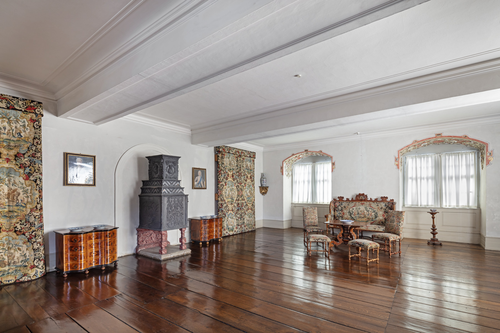




Wikibase link: [https://computational-publishing-service.wikibase.cloud/entity/Q234](https://computational-publishing-service.wikibase.cloud/entity/Q234)

Title: Einstige Tafelstube & Raum 69a – nach Südosten

Year: 2018-01-01T00:00:00Z

Description: Wolfgang Beringer, Baumeister und Steinmetz - Georg Stegle, Baumeister - Entwurf: Georges Robin, Architekt - Elias Gunzenhäuser, Zimmermann - Weikersheim, Marktplatz 11 - ab 1595



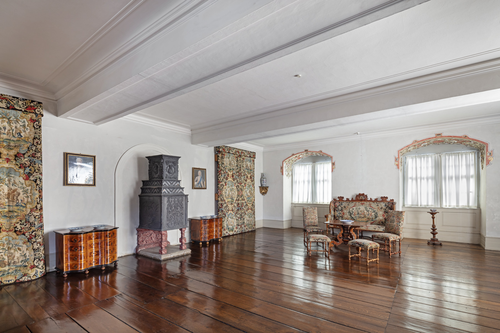

In [3]:
get_img("Q231")
#Bild Tafelstube

<hr>

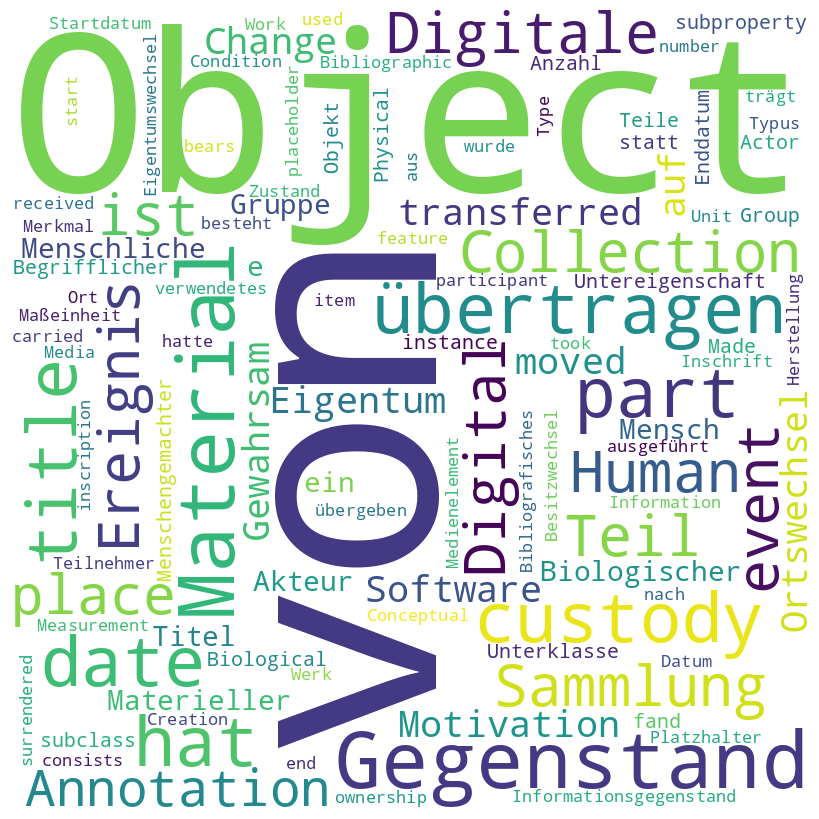

In [4]:
get_graph()